### Parameters

In [1]:
ND=1
hidden_layer_size=5
activation = 'relu'
cross_validation_window=1
SKILL_SAVEFILE = 'POELM_SKILL.png'
HINDCAST_SAVEFILE = 'POELM_HCSTS.png'

### Load Data

In [2]:
import xarray as xr 
import xcast as xc 
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np

india = xr.open_dataset('IMD-PR-JJAS-1982-2018.nc').rf
nmme = xr.open_dataset('NMME-INDIA-JJAS-PR.nc').prec

#now one-hot encode observations - this happens inside of crossvalidation too, but we need it for skill 
ohc = xc.RankedTerciles()
ohc.fit(india)
india_ohc = ohc.transform(india)

### Cross Validation 

In [3]:
poelm_xval = []
i = 1
start = pd.Timestamp.now()
for x_train, y_train, x_test, y_test in xc.CrossValidator(nmme, india.load(), window=cross_validation_window):
    ohc = xc.RankedTerciles()
    ohc.fit(y_train)
    ohc_y_train = ohc.transform(y_train)
    
    poelm = xc.cPOELM(ND=ND, hidden_layer_size=hidden_layer_size, activation=activation)
    poelm.fit(x_train, ohc_y_train)
    poelm_preds = poelm.predict(x_test)
    poelm_xval.append(poelm_preds.isel(S=cross_validation_window // 2))
    print('Fiting Window {}/37 - {}'.format(i, pd.Timestamp.now() - start), end='\r')
    i+= 1
poelm = xr.concat(poelm_xval, 'S').mean('ND')
poelm.to_netcdf(HINDCAST_SAVEFILE)

### Calculate Skill

In [4]:
groc = xc.GeneralizedROC(poelm, india_ohc)
poelm_rps = xc.RankProbabilityScore(poelm, india_ohc)
climatological_odds = xr.ones_like(poelm) * 0.33 
climo_rps = xc.RankProbabilityScore(climatological_odds, india_ohc)
rpss = 1 - ( poelm_rps / climo_rps)

### Plot Skill

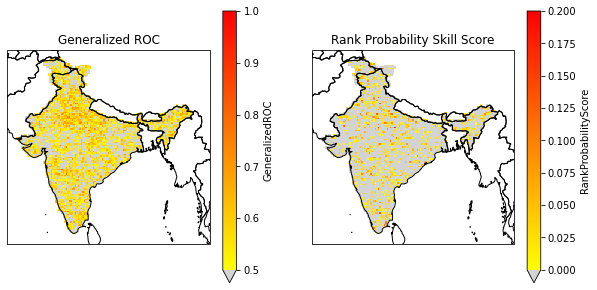

In [5]:
import cartopy.crs as ccrs 
import matplotlib.pyplot as plt 
import cartopy.feature as cfeature

cmap = plt.get_cmap('autumn_r')
cmap.set_under('lightgray')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
groc.plot(ax=ax[0], vmin=0.5, vmax=1, cmap=cmap)
states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_0_countries', scale='50m', facecolor='none')
ax[0].add_feature(states_provinces)
ax[0].set_title('Generalized ROC')

rpss.plot(ax=ax[1], vmin=0, vmax=0.2, cmap=cmap)
ax[1].add_feature(states_provinces)
ax[1].set_title('Rank Probability Skill Score')
plt.savefig(SKILL_SAVEFILE)
plt.show()

### ROC Curves

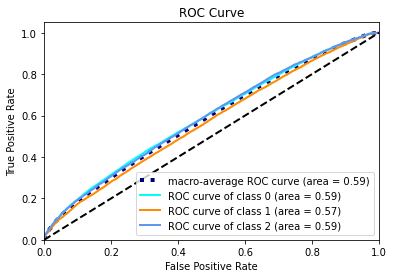

In [6]:
xc.view_roc(poelm.where(rpss.mean('M').mean('SKILLDIM') > 0, other=np.nan), india_ohc.where(rpss.mean('M').mean('SKILLDIM') > 0, other=np.nan),  y_feature_dim='C')